# Day 39: Density-Based Clustering with DBSCAN


## Introduction to DBSCAN

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a powerful clustering algorithm that groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions. Unlike K-Means, which requires specifying the number of clusters beforehand, DBSCAN automatically determines the number of clusters based on the data's density structure.

DBSCAN is particularly valuable in real-world applications because it can:
- Discover clusters of arbitrary shapes (not just spherical clusters)
- Identify and handle noise/outliers effectively
- Automatically determine the number of clusters
- Work well with spatial data and datasets with varying densities

### Learning Objectives

By the end of this lesson, you will be able to:
- Understand the core concepts of density-based clustering
- Explain the role of epsilon (ε) and MinPts parameters in DBSCAN
- Implement DBSCAN using scikit-learn
- Visualize and interpret DBSCAN clustering results
- Compare DBSCAN with other clustering algorithms like K-Means
- Apply DBSCAN to real-world datasets with noise and irregular cluster shapes


## Theory of Density-Based Clustering

### What is Density-Based Clustering?

Density-based clustering is based on the idea that clusters are dense regions in the data space, separated by regions of lower density. DBSCAN groups together points that are closely packed (points with many nearby neighbors), while marking points that lie alone in low-density regions as outliers.

### Key Concepts in DBSCAN

DBSCAN relies on three fundamental concepts:

1. **Core Points**: A point is a core point if it has at least MinPts points (including itself) within a distance of ε (epsilon).

2. **Border Points**: A point is a border point if it is not a core point but falls within the ε-neighborhood of a core point.

3. **Noise Points**: A point is considered noise (or an outlier) if it is neither a core point nor a border point.

### Mathematical Foundation

The DBSCAN algorithm is governed by two key parameters:

**1. Epsilon (ε)**: The maximum distance between two points for them to be considered neighbors.

The ε-neighborhood of a point $p$ is defined as:
$$N_\varepsilon(p) = \{q \in D \mid dist(p, q) \leq \varepsilon\}$$

where $D$ is the dataset and $dist(p, q)$ is the distance function (typically Euclidean distance).

**2. MinPts**: The minimum number of points required to form a dense region (including the point itself).

A point $p$ is a **core point** if:
$$|N_\varepsilon(p)| \geq MinPts$$

**Density-Reachable**: A point $q$ is directly density-reachable from point $p$ if:
1. $q \in N_\varepsilon(p)$ (q is in p's ε-neighborhood)
2. $p$ is a core point

A point $q$ is density-reachable from $p$ if there is a chain of points $p_1, p_2, ..., p_n$ where $p_1 = p$ and $p_n = q$, such that each $p_{i+1}$ is directly density-reachable from $p_i$.

**Density-Connected**: Two points $p$ and $q$ are density-connected if there exists a core point $o$ such that both $p$ and $q$ are density-reachable from $o$.

A **cluster** in DBSCAN is defined as a maximal set of density-connected points.

### DBSCAN Algorithm Steps

1. For each point in the dataset:
   - Determine if it's a core point by counting neighbors within ε distance
2. For each core point that hasn't been assigned to a cluster:
   - Create a new cluster
   - Add all density-reachable points to this cluster
3. Assign border points to clusters
4. Mark remaining points as noise

### Advantages of DBSCAN

- **No need to specify number of clusters**: The algorithm discovers clusters naturally
- **Handles arbitrary shapes**: Can find non-spherical clusters
- **Robust to outliers**: Explicitly identifies noise points
- **Handles varying densities**: With proper parameter tuning

### Disadvantages of DBSCAN

- **Sensitive to parameters**: ε and MinPts must be chosen carefully
- **Struggles with varying densities**: If clusters have very different densities
- **High-dimensional data**: Distance-based methods suffer from the curse of dimensionality


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("NumPy version:", np.__version__)


Libraries imported successfully!
NumPy version: 2.3.4


## Visualizing DBSCAN Concepts

Let's visualize how DBSCAN identifies core points, border points, and noise points.


In [2]:
# Create a simple dataset to illustrate DBSCAN concepts
np.random.seed(42)

# Generate sample data with clusters and noise
X, _ = make_blobs(n_samples=200, centers=3, n_features=2, 
                  center_box=(-10, 10), cluster_std=1.5, random_state=42)

# Add some noise points
noise = np.random.uniform(-12, 12, size=(20, 2))
X = np.vstack([X, noise])

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Identify core samples
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Count clusters and noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Number of core points: {len(dbscan.core_sample_indices_)}")


Number of clusters: 3
Number of noise points: 21
Number of core points: 190


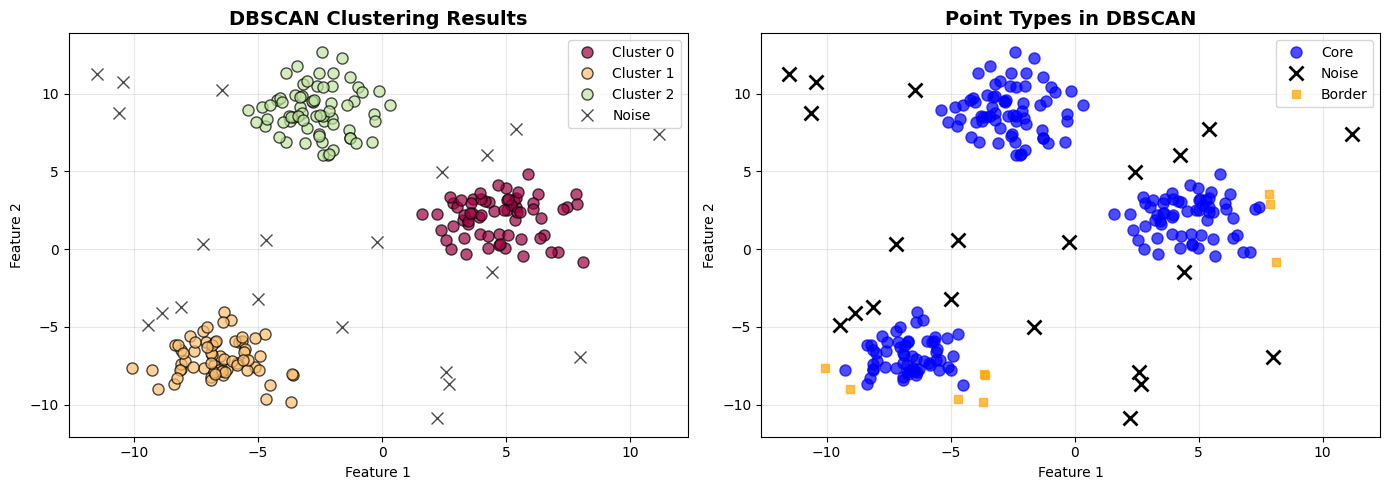


Summary:
- Core points (blue circles): Points with at least MinPts neighbors within ε
- Border points (orange squares): Points in ε-neighborhood of core points
- Noise points (black X): Points that are neither core nor border points


In [3]:
# Visualize the clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Show all points colored by cluster
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points in black
        col = 'black'
        marker = 'x'
        label = 'Noise'
    else:
        marker = 'o'
        label = f'Cluster {k}'
    
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    ax1.plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=col,
             markeredgecolor='k', markersize=8, label=label, alpha=0.7)

ax1.set_title('DBSCAN Clustering Results', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distinguish core, border, and noise points
for i, point in enumerate(X):
    if labels[i] == -1:
        # Noise point
        ax2.plot(point[0], point[1], 'x', color='black', markersize=10, 
                markeredgewidth=2, label='Noise' if i == np.where(labels == -1)[0][0] else '')
    elif core_samples_mask[i]:
        # Core point
        ax2.plot(point[0], point[1], 'o', color='blue', markersize=8, 
                alpha=0.7, label='Core' if i == dbscan.core_sample_indices_[0] else '')
    else:
        # Border point
        ax2.plot(point[0], point[1], 's', color='orange', markersize=6, 
                alpha=0.7, label='Border' if i == np.where((labels != -1) & (~core_samples_mask))[0][0] else '')

ax2.set_title('Point Types in DBSCAN', fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"- Core points (blue circles): Points with at least MinPts neighbors within ε")
print(f"- Border points (orange squares): Points in ε-neighborhood of core points")
print(f"- Noise points (black X): Points that are neither core nor border points")


## Effect of Parameters on DBSCAN

The performance of DBSCAN heavily depends on choosing appropriate values for ε (epsilon) and MinPts. Let's visualize how different parameter values affect clustering results.


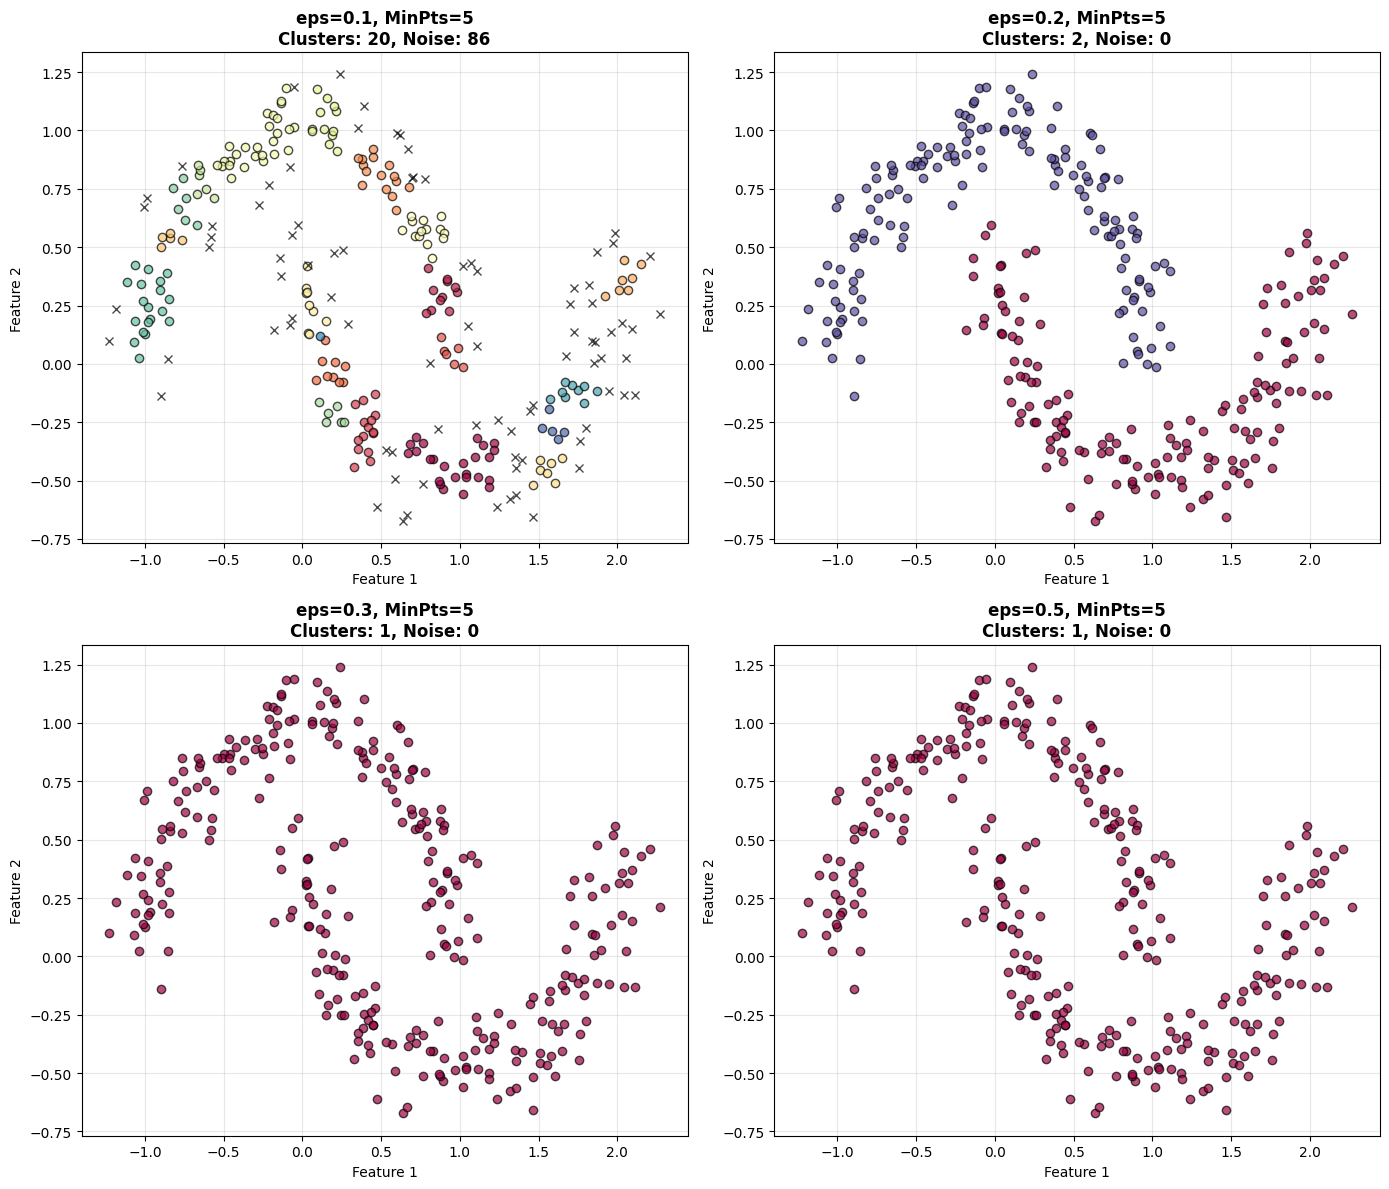

Observations:
- Too small ε: Many small clusters and noise points
- Too large ε: All points may merge into one cluster
- Optimal ε: Captures the natural structure of the data


In [4]:
# Generate a dataset with clear structure
np.random.seed(42)
X_moons, _ = make_moons(n_samples=300, noise=0.1, random_state=42)

# Test different epsilon values
eps_values = [0.1, 0.2, 0.3, 0.5]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_moons)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Plot
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
        else:
            marker = 'o'
        
        class_member_mask = (labels == k)
        xy = X_moons[class_member_mask]
        axes[idx].plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=col,
                      markeredgecolor='k', markersize=6, alpha=0.7)
    
    axes[idx].set_title(f'eps={eps}, MinPts=5\nClusters: {n_clusters}, Noise: {n_noise}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Too small ε: Many small clusters and noise points")
print("- Too large ε: All points may merge into one cluster")
print("- Optimal ε: Captures the natural structure of the data")


## DBSCAN vs K-Means Clustering

Let's compare DBSCAN with K-Means on datasets with different characteristics to understand when each algorithm performs better.


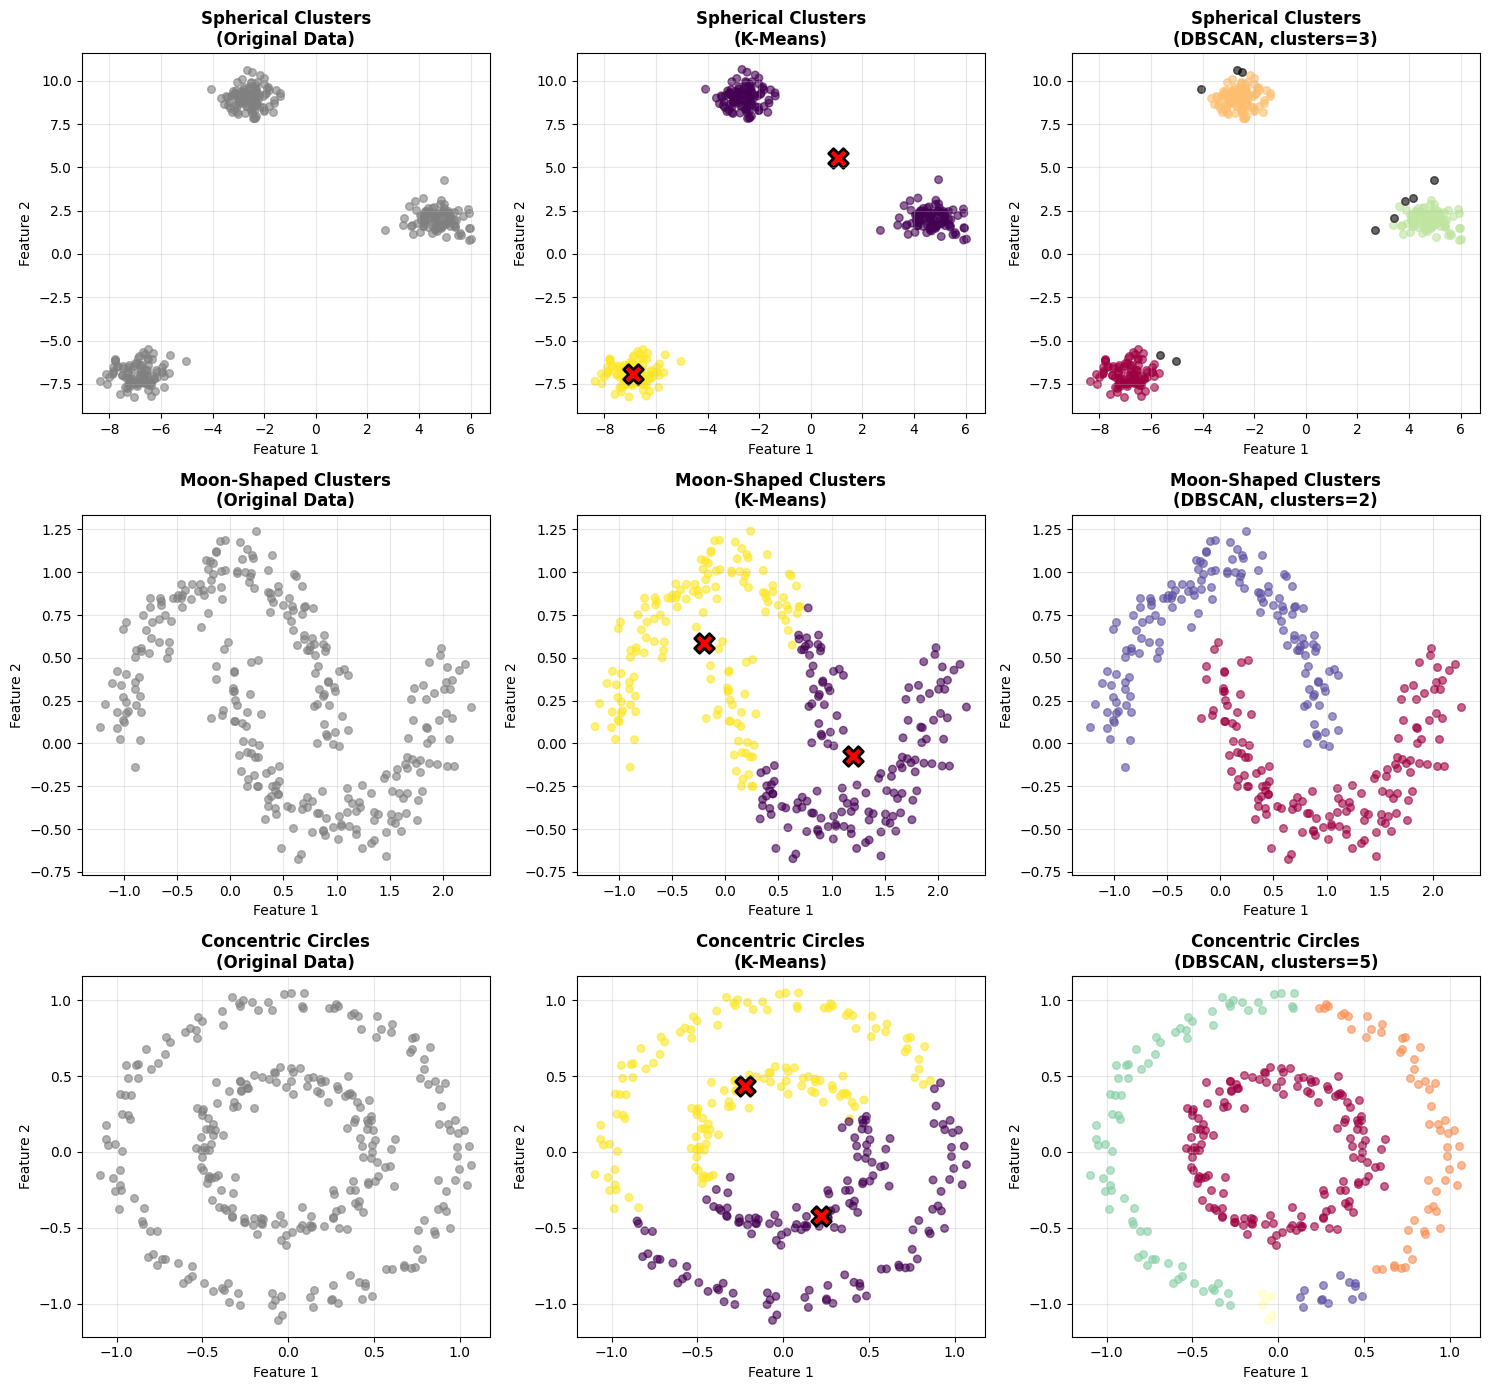

Comparison Summary:

1. Spherical Clusters:
   - K-Means: Works well for spherical, well-separated clusters
   - DBSCAN: Also works well, may identify some noise

2. Moon-Shaped Clusters:
   - K-Means: Fails to capture the true structure (spherical assumption)
   - DBSCAN: Successfully identifies the moon shapes

3. Concentric Circles:
   - K-Means: Cannot separate concentric patterns
   - DBSCAN: Can separate circles based on density


In [5]:
# Create three different datasets
np.random.seed(42)

# Dataset 1: Circular clusters (K-Means should work well)
X1, y1 = make_blobs(n_samples=300, centers=3, n_features=2, 
                    cluster_std=0.6, random_state=42)

# Dataset 2: Moon-shaped clusters (DBSCAN should work better)
X2, y2 = make_moons(n_samples=300, noise=0.1, random_state=42)

# Dataset 3: Concentric circles (DBSCAN should work better)
X3, y3 = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

datasets = [
    (X1, 'Spherical Clusters'),
    (X2, 'Moon-Shaped Clusters'),
    (X3, 'Concentric Circles')
]

fig, axes = plt.subplots(3, 3, figsize=(15, 14))

for i, (X, title) in enumerate(datasets):
    # Original data
    axes[i, 0].scatter(X[:, 0], X[:, 1], c='gray', s=30, alpha=0.6)
    axes[i, 0].set_title(f'{title}\n(Original Data)', fontweight='bold')
    axes[i, 0].grid(True, alpha=0.3)
    
    # K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    axes[i, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=30, alpha=0.6)
    axes[i, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                      c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    axes[i, 1].set_title(f'{title}\n(K-Means)', fontweight='bold')
    axes[i, 1].grid(True, alpha=0.3)
    
    # DBSCAN
    if i == 0:
        eps = 0.5
    elif i == 1:
        eps = 0.2
    else:
        eps = 0.15
    
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)
    
    unique_labels = set(dbscan_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
        
        class_member_mask = (dbscan_labels == k)
        xy = X[class_member_mask]
        axes[i, 2].scatter(xy[:, 0], xy[:, 1], c=[col], s=30, alpha=0.6)
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    axes[i, 2].set_title(f'{title}\n(DBSCAN, clusters={n_clusters_dbscan})', fontweight='bold')
    axes[i, 2].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("Comparison Summary:")
print("\n1. Spherical Clusters:")
print("   - K-Means: Works well for spherical, well-separated clusters")
print("   - DBSCAN: Also works well, may identify some noise")
print("\n2. Moon-Shaped Clusters:")
print("   - K-Means: Fails to capture the true structure (spherical assumption)")
print("   - DBSCAN: Successfully identifies the moon shapes")
print("\n3. Concentric Circles:")
print("   - K-Means: Cannot separate concentric patterns")
print("   - DBSCAN: Can separate circles based on density")


## Practical Implementation with Real-World Dataset

Let's apply DBSCAN to a more realistic scenario using the Iris dataset, which contains measurements of iris flowers.


In [6]:
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
X_iris = iris.data
y_true = iris.target

print("Iris Dataset Information:")
print(f"Number of samples: {X_iris.shape[0]}")
print(f"Number of features: {X_iris.shape[1]}")
print(f"Feature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")
print(f"\nFirst 5 samples:")
print(X_iris[:5])


Iris Dataset Information:
Number of samples: 150
Number of features: 4
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']

First 5 samples:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


In [7]:
# Standardize features (important for distance-based algorithms)
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Apply DBSCAN
dbscan_iris = DBSCAN(eps=0.5, min_samples=5)
labels_iris = dbscan_iris.fit_predict(X_iris_scaled)

# Cluster analysis
n_clusters_iris = len(set(labels_iris)) - (1 if -1 in labels_iris else 0)
n_noise_iris = list(labels_iris).count(-1)

print(f"Number of clusters found: {n_clusters_iris}")
print(f"Number of noise points: {n_noise_iris}")
print(f"\nCluster distribution:")
for i in range(-1, n_clusters_iris):
    count = list(labels_iris).count(i)
    if i == -1:
        print(f"  Noise: {count} points")
    else:
        print(f"  Cluster {i}: {count} points")


Number of clusters found: 2
Number of noise points: 34

Cluster distribution:
  Noise: 34 points
  Cluster 0: 45 points
  Cluster 1: 71 points


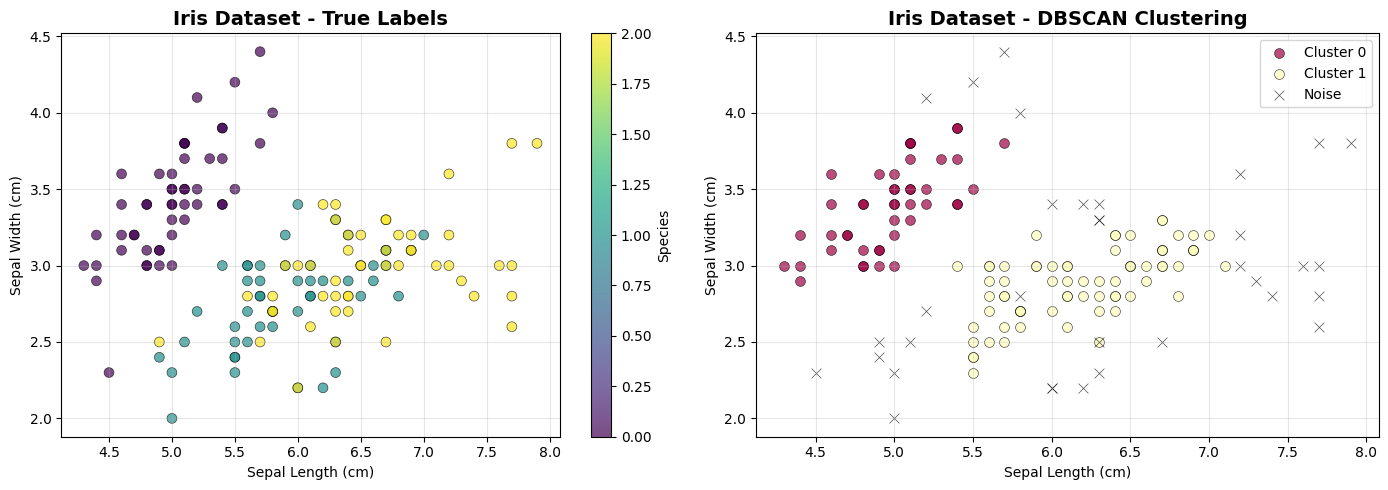


Observation:
DBSCAN may not perfectly match the true species labels, but it identifies
dense regions in the feature space based on similarity of measurements.


In [8]:
# Visualize using first two features (sepal length and sepal width)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# True labels
scatter1 = ax1.scatter(X_iris[:, 0], X_iris[:, 1], c=y_true, cmap='viridis', 
                       s=50, edgecolors='black', linewidths=0.5, alpha=0.7)
ax1.set_title('Iris Dataset - True Labels', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sepal Length (cm)')
ax1.set_ylabel('Sepal Width (cm)')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Species')

# DBSCAN labels
unique_labels_iris = set(labels_iris)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_iris)))

for k, col in zip(unique_labels_iris, colors):
    if k == -1:
        col = 'black'
        marker = 'x'
        label = 'Noise'
    else:
        marker = 'o'
        label = f'Cluster {k}'
    
    class_member_mask = (labels_iris == k)
    xy = X_iris[class_member_mask]
    ax2.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=50, 
               edgecolors='black', linewidths=0.5, alpha=0.7, label=label)

ax2.set_title('Iris Dataset - DBSCAN Clustering', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sepal Length (cm)')
ax2.set_ylabel('Sepal Width (cm)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation:")
print("DBSCAN may not perfectly match the true species labels, but it identifies")
print("dense regions in the feature space based on similarity of measurements.")


## Finding Optimal Epsilon: The K-Distance Graph

One common method to determine an appropriate value for ε is to use a k-distance graph, where we plot the distance to the k-th nearest neighbor for each point, sorted in ascending order. The "elbow" in this plot suggests a good ε value.


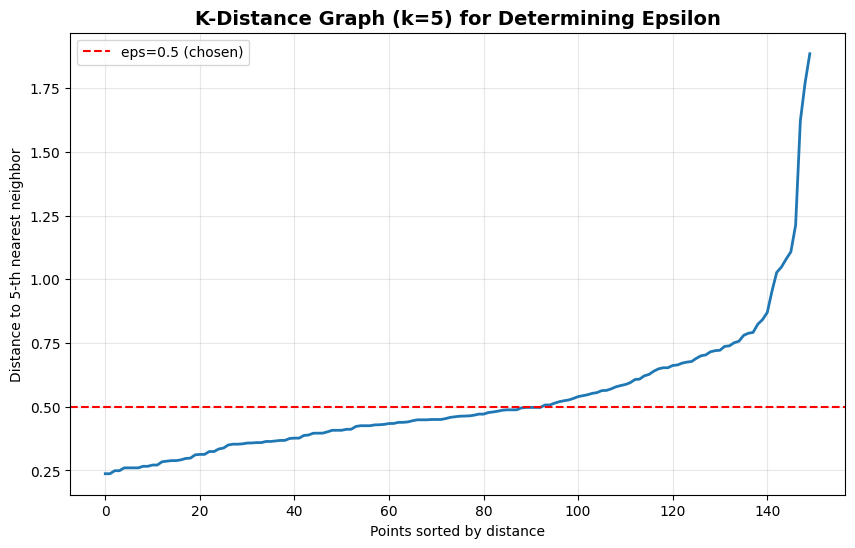

How to use this graph:
1. Look for the 'elbow' point where the distance starts increasing rapidly
2. The y-value at the elbow suggests a good epsilon value
3. In this case, around 0.4-0.6 seems reasonable

Note: This is a heuristic method; you may need to experiment with different values


In [9]:
from sklearn.neighbors import NearestNeighbors

# Calculate distances to k-th nearest neighbor
k = 5  # MinPts value
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_iris_scaled)
distances, indices = neighbors.kneighbors(X_iris_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', label='eps=0.5 (chosen)')
plt.title('K-Distance Graph (k=5) for Determining Epsilon', 
         fontsize=14, fontweight='bold')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("How to use this graph:")
print("1. Look for the 'elbow' point where the distance starts increasing rapidly")
print("2. The y-value at the elbow suggests a good epsilon value")
print("3. In this case, around 0.4-0.6 seems reasonable")
print("\nNote: This is a heuristic method; you may need to experiment with different values")


## Hands-On Exercise: Customer Segmentation

In this exercise, you'll apply DBSCAN to a customer segmentation problem. Imagine you have data about customers' annual income and spending score, and you want to identify distinct customer groups and potential outliers.

### Exercise Tasks:
1. Generate synthetic customer data
2. Apply DBSCAN with different parameter settings
3. Visualize and interpret the results
4. Compare with K-Means clustering
5. Identify which customers might be outliers (unusual spending patterns)


In [10]:
# Generate synthetic customer data
np.random.seed(42)

# Create customer groups with different characteristics
# Group 1: Low income, low spending
group1 = np.random.randn(50, 2) * 5 + [30, 30]

# Group 2: Medium income, medium spending
group2 = np.random.randn(60, 2) * 6 + [50, 50]

# Group 3: High income, high spending
group3 = np.random.randn(55, 2) * 7 + [75, 75]

# Group 4: High income, low spending (savers)
group4 = np.random.randn(40, 2) * 4 + [75, 30]

# Add some outliers
outliers = np.random.uniform(0, 100, size=(10, 2))

# Combine all data
X_customers = np.vstack([group1, group2, group3, group4, outliers])

print(f"Total number of customers: {len(X_customers)}")
print(f"Feature 1: Annual Income (scaled)")
print(f"Feature 2: Spending Score (scaled)")
print(f"\nData shape: {X_customers.shape}")
print(f"\nSample data (first 5 customers):")
print(X_customers[:5])


Total number of customers: 215
Feature 1: Annual Income (scaled)
Feature 2: Spending Score (scaled)

Data shape: (215, 2)

Sample data (first 5 customers):
[[32.48357077 29.30867849]
 [33.23844269 37.61514928]
 [28.82923313 28.82931522]
 [37.89606408 33.83717365]
 [27.65262807 32.71280022]]


In [11]:
# Apply DBSCAN to customer data
dbscan_customers = DBSCAN(eps=8, min_samples=5)
customer_labels = dbscan_customers.fit_predict(X_customers)

# Also apply K-Means for comparison
kmeans_customers = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans_customers.fit_predict(X_customers)

# Analyze DBSCAN results
n_clusters_customers = len(set(customer_labels)) - (1 if -1 in customer_labels else 0)
n_noise_customers = list(customer_labels).count(-1)

print(f"DBSCAN Results:")
print(f"  Number of customer segments: {n_clusters_customers}")
print(f"  Number of outlier customers: {n_noise_customers}")
print(f"\nSegment sizes:")
for i in range(-1, n_clusters_customers):
    count = list(customer_labels).count(i)
    if i == -1:
        print(f"  Outliers: {count} customers")
    else:
        print(f"  Segment {i}: {count} customers")


DBSCAN Results:
  Number of customer segments: 4
  Number of outlier customers: 6

Segment sizes:
  Outliers: 6 customers
  Segment 0: 50 customers
  Segment 1: 63 customers
  Segment 2: 55 customers
  Segment 3: 41 customers


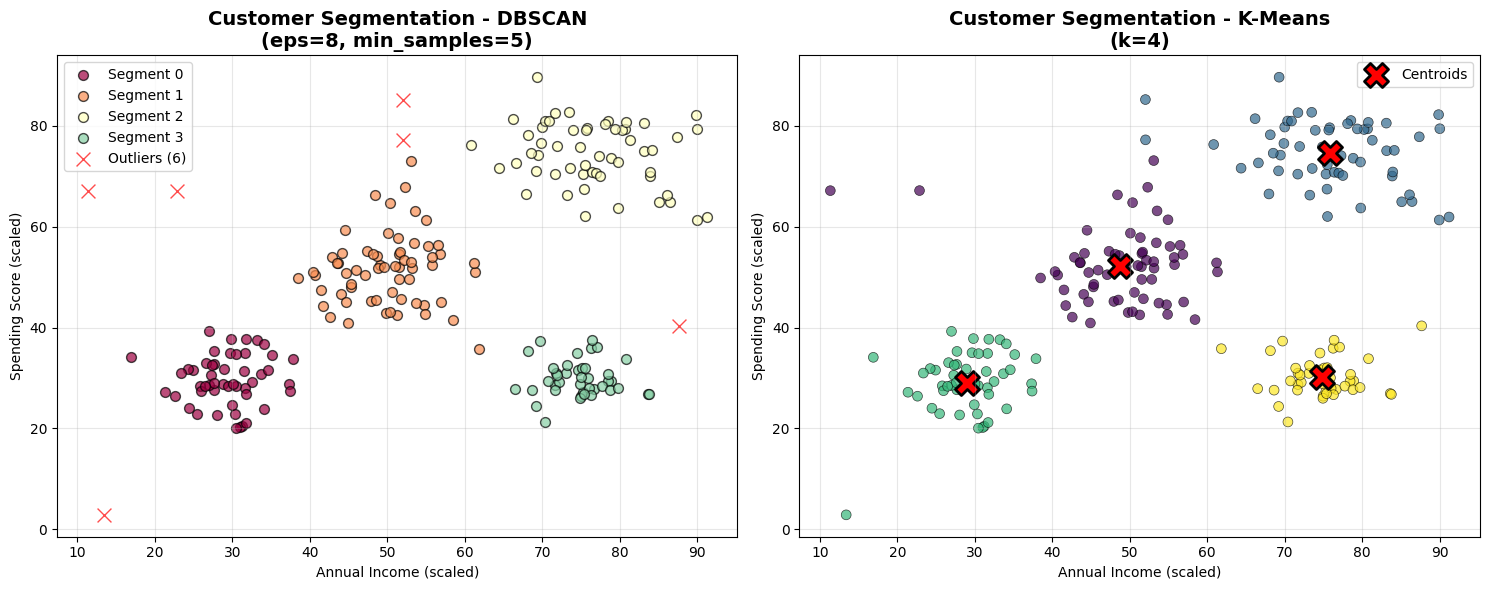


Interpretation:
- DBSCAN identifies natural groupings and marks unusual customers as outliers
- K-Means forces all customers into k segments, even outliers
- DBSCAN better captures the irregular shapes of customer groups
- Outliers (red X) might represent VIP customers or unusual spending patterns


In [12]:
# Visualize customer segmentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# DBSCAN results
unique_labels_customers = set(customer_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_customers)))

for k, col in zip(unique_labels_customers, colors):
    if k == -1:
        col = 'red'
        marker = 'x'
        label = f'Outliers ({n_noise_customers})'
        size = 100
    else:
        marker = 'o'
        label = f'Segment {k}'
        size = 50
    
    class_member_mask = (customer_labels == k)
    xy = X_customers[class_member_mask]
    ax1.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, 
               edgecolors='black', linewidths=1, alpha=0.7, label=label)

ax1.set_title('Customer Segmentation - DBSCAN\n(eps=8, min_samples=5)', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('Annual Income (scaled)')
ax1.set_ylabel('Spending Score (scaled)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# K-Means results for comparison
scatter2 = ax2.scatter(X_customers[:, 0], X_customers[:, 1], 
                      c=kmeans_labels, cmap='viridis', s=50, 
                      edgecolors='black', linewidths=0.5, alpha=0.7)
ax2.scatter(kmeans_customers.cluster_centers_[:, 0], 
           kmeans_customers.cluster_centers_[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', linewidths=2, label='Centroids')
ax2.set_title('Customer Segmentation - K-Means\n(k=4)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Annual Income (scaled)')
ax2.set_ylabel('Spending Score (scaled)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- DBSCAN identifies natural groupings and marks unusual customers as outliers")
print("- K-Means forces all customers into k segments, even outliers")
print("- DBSCAN better captures the irregular shapes of customer groups")
print("- Outliers (red X) might represent VIP customers or unusual spending patterns")


## Key Takeaways

1. **DBSCAN is density-based**: It groups together points that are closely packed and marks isolated points as noise/outliers.

2. **Two critical parameters**:
   - **ε (epsilon)**: Defines the neighborhood distance
   - **MinPts**: Minimum points needed to form a dense region

3. **Point types in DBSCAN**:
   - **Core points**: Have at least MinPts neighbors within ε distance
   - **Border points**: Not core points but within ε of a core point
   - **Noise points**: Neither core nor border points

4. **Advantages over K-Means**:
   - No need to specify number of clusters in advance
   - Can find arbitrarily shaped clusters
   - Robust to outliers
   - Better for datasets with noise

5. **When to use DBSCAN**:
   - Clusters have irregular shapes
   - Dataset contains noise/outliers
   - Number of clusters is unknown
   - Clusters have similar density

6. **Parameter selection**:
   - Use k-distance graphs to estimate ε
   - MinPts typically set to 2×dimensions or higher
   - May require experimentation and domain knowledge

7. **Limitations**:
   - Sensitive to parameter choices
   - Struggles with varying density clusters
   - Performance degrades in high dimensions
   - Computational cost higher than K-Means for large datasets


## Further Resources

### Documentation and Tutorials
1. [Scikit-learn DBSCAN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) - Official documentation with detailed parameter explanations
2. [DBSCAN Clustering Tutorial](https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/) - Comprehensive tutorial with examples
3. [DBSCAN Parameter Selection](https://www.reneshbedre.com/blog/dbscan.html) - Guide on choosing optimal epsilon and MinPts

### Academic Papers
4. [Original DBSCAN Paper](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf) - Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996). "A density-based algorithm for discovering clusters in large spatial databases with noise"

### Interactive Learning
5. [DBSCAN Visualizer](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) - Interactive visualization to understand how parameters affect clustering

### Advanced Topics
6. [HDBSCAN](https://hdbscan.readthedocs.io/) - Hierarchical DBSCAN for varying density clusters
7. [Comparing Clustering Algorithms](https://scikit-learn.org/stable/modules/clustering.html) - Scikit-learn's guide to different clustering methods
